# Camera API demo (or something)

## Setup

### Modules

In [1]:
from pathlib import Path
import threading


import ids_peak.ids_peak as idsp
import ids_peak_ipl.ids_peak_ipl as idsp_ipl
from matplotlib import pyplot as plt
import numpy

from camera import Camera
from cli_interface import Interface

### Data

In [2]:
DIR_CONFIGS = "configs"
FILENAME_CONFIG = "cam_ids_config.cset"

path_config = Path(DIR_CONFIGS) / FILENAME_CONFIG

### Initialization

In [3]:
idsp.Library.Initialize()

device_manager = idsp.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()
print(device_descriptors.empty())

False


In [4]:
device_descriptor = device_manager.Devices()[0]

name_model = device_descriptor.ModelName()
name_interface = device_descriptor.ParentInterface().DisplayName()
name_system = device_descriptor.ParentInterface().ParentSystem().DisplayName()
version_system = device_descriptor.ParentInterface().ParentSystem().Version()

print(name_model)
print(name_interface)
print(name_system)
print(version_system)

U3-36PxXLS-C
IDS U3V Interface
IDS GenICam Producer (U3V)
1.15.0.0


In [13]:
from sensor_msgs.msg import Image

ModuleNotFoundError: No module named 'sensor_msgs'

In [5]:
device = Camera(device_manager)

Allocated buffers, finished opening device


In [6]:
device.start_acquisition()

True

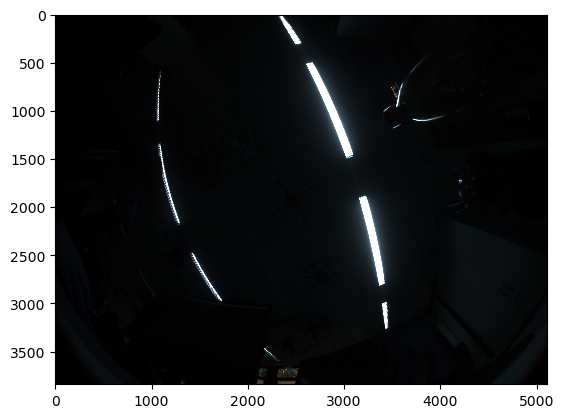

In [10]:
img = device.get_data_stream_image()
plt.imshow(img.get_numpy_3D(), interpolation="nearest")
plt.show()

In [9]:
# camera.close()
camera = None
idsp.Library.Close()

In [6]:
device = device_descriptor.OpenDevice(idsp.DeviceAccessType_Control)

In [7]:
nodemap_remote_device = device.RemoteDevice().NodeMaps()[0]

In [17]:
for e in list(nodemap_remote_device.FindNode("UserSetSelector").Entries()):
    print(e.DisplayName())

Default
User Set 0
User Set 1
Linescan
Linescan High Speed
Long Exposure
High Speed


In [22]:
for node in nodemap_remote_device.Nodes():
    print(node.DisplayName())

Root
TLParamsLockedCategory
AcquisitionControl
TransferControl
DeviceControl
TestControl
ManufacturerInfo
FileAccessControl
SequencerControl
EventControl
UserSetControl
ProtectionControl
LEDControl
DigitalIOControl
ImageFormatControl
ImageCorrectionControl
AnalogControl
TransportLayerControl
Trigger Selector
Trigger Mode
Trigger Source
Trigger Activation
Trigger Software
Trigger Delay
Trigger Divider
Acquisition Mode
Acquisition Frame Count
Sensor Shutter Mode
Acquisition Abort
Acquisition Frame Rate Target
SensorFrameTimeClocksTarget
Acquisition Frame Rate Target Enable
SensorLineClocks
Acquisition Start
Acquisition Stop
SensorClockFrequency
Exposure Time
SensorExposureTimeClocks
Acquisition Frame Rate
SensorFrameTimeClocks
Exposure Mode
Transfer Control Mode
Device Firmware Version
Device User ID
Device Reset
Device Boot Status
Device Boot Status Additional Information 1
Device Boot Status Additional Information 2
Device Link Speed
Device SFNC Version Major
Device SFNC Version Minor


In [19]:
nodemap_remote_device.HasNode("GainAuto")

False

In [ ]:
all_entries = nodemap_remote_device.FindNode("GainAuto").Entries()

print(all_entries)

In [18]:
name_sensor = nodemap_remote_device.FindNode("Gamma").Value()

print(name_sensor)

NotFoundException: Error-Code: 11 (PEAK_RETURN_CODE_NOT_FOUND) | Error-Description: There is no node with the given name (Gamma)!

In [8]:
min_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Minimum()
max_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Maximum()
max_width = nodemap_remote_device.FindNode("WidthMax").Value()
max_height = nodemap_remote_device.FindNode("HeightMax").Value()

exposure_time = nodemap_remote_device.FindNode("ExposureTime").Value()

print(exposure_time)
print(min_exposure_time)
print(max_exposure_time)
print(max_width)
print(max_height)
print(nodemap_remote_device.FindNode("Width").Value())
print(nodemap_remote_device.FindNode("Height").Value())

15000.06996116532
31.712621482379113
1999005.0951417673
5136
3856
5112
3840


In [9]:
str(path_config)

'configs/cam_ids_config.cset'

In [39]:
def load_settings():
    nodemap_remote_device.LoadFromFile(str(path_config))

In [38]:
def store_settings():
    nodemap_remote_device.StoreToFile("test_settings.cset")

In [ ]:
def close():
    device = None

In [ ]:
def capture():
    # TODO: Timestamp: https://www.1stvision.com/cameras/IDS/IDS-manuals/uEye_Manual/is_getimageinfo.html
    if not device.start_acquisition():
        print("Unable to start acquisition!")
        return
    else:
        print("Acquisition started")

    # The acquisition thread takes care of waiting for finished buffers
    # and either recording the images or passing them to the live view
    thread = threading.Thread(target=device.acquisition_thread, args=())
    ui.acquisition_thread = thread
    thread.start()
    ui.start_interface()

In [ ]:
index = 0

# Get buffer from device's DataStream. Wait 5000 ms. The buffer is automatically locked until it is queued again.
buffer = m_data_stream.WaitForFinishedBuffer(5000)

# Create IDS peak IPL image from buffer
image = idsp_ipl.Image.CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())

# Create IDS peak IPL image for debayering and convert it to RGBa8 format
image_processed = image.ConvertTo(idsp_ipl.PixelFormatName_BGRa8, idsp_ipl.ConversionMode_Fast)

# Queue buffer again
m_data_stream.QueueBuffer(buffer)

file = "test_" + index + ".jpg"
idsp_ipl.ImageWriter.Write(file, image_processed)
index = index + 1

In [6]:
camera = None

In [ ]:
def done_recording(self, stats: RecordingStatistics):
    if stats.frames_encoded != 0:
        print(
            "Recording done!\n"
            "Statistics:\n"
            f"  Total Frames recorded: {stats.frames_encoded}\n"
            f"  Frames dropped by video recorder: {stats.frames_video_dropped}\n"
            f"  Frames dropped by image stream: {stats.frames_stream_dropped}\n"
            f"  Frames lost by image stream: {stats.frames_lost_stream}\n"
            f"  Frame rate: {stats.fps()}"
        )